## Busqueda y extracción de tweets usando la librería tweepy.

En este notebook vamos a conectarnos mediante la libreria tweepy al api de twitter para extraer en streaming los tweets que los usuarios estén escribiendo en el momento sobre unos topics que anteriormente hemos extraido en las webs de noticias.

In [1]:
#Import the necessary methods from tweepy library
import tweepy
import pandas as pd
import json
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import numpy as np
import re
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import nltk
from wordcloud import WordCloud
from collections import Counter

In [2]:
# Variables that contains the user credentials to access Twitter API 
consumer_key= 'XXXXXXXXXXX'
consumer_secret= 'XXXXXXXXXXX'
access_token= 'XXXXXXXXXXX'
access_token_secret= 'XXXXXXXXXXX'

In [3]:
# Setup tweepy to authenticate with Twitter credentials:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

# Create the api to connect to twitter with your creadentials
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

try:
    api.verify_credentials()
    print("Authentication OK")
except:
    print("Error during authentication")

Authentication OK


Esta función es la que se conecta a la api de Twitter, se le pasan 4 parámetros (3 de ellos se pueden modificar, o los busca en función en este caso del proyecto creado) el topic a buscar, el numero máximo de tweets, el idioma y luego un 4 parámetro para controlar en un campo del dataframe el numero entero del topic (para tableu).

La api de Twitter te da el tweet en formato json, mirando en la documentación oficial de tweepy 
( http://docs.tweepy.org/en/v3.9.0/index.html ) podemos encontrar los parametros que queremos seleccionar del tweet.

La función lo pasa a un dataframe y guarda un archivo csv por cada búsqueda de topic.

In [4]:
def readTweeter(keyword,max_tweets,idiom, num):
    type_result = "recent" #"recent" "popular" (se puede cambiar el tipo de busqueda)
    searched_tweets = [status for status in tweepy.Cursor(api.search, q=keyword, tweet_mode="extended",
                                                      result_type= type_result, lang = idiom).items(max_tweets)]

    #Creating Dataframe of Tweets
    #Cleaning searched tweets and converting into Dataframe
    my_list_of_dicts = []
    
    for each_json_tweet in searched_tweets:
        my_list_of_dicts.append(each_json_tweet._json)

    with open(keyword + '.txt', 'w') as file:
            file.write(json.dumps(my_list_of_dicts, indent=4))

    my_demo_list = []
    with open(keyword + '.txt', encoding='utf-8') as json_file:  
        all_data = json.load(json_file)
        for each_dictionary in all_data:
            user = each_dictionary['user']['screen_name']
            location = each_dictionary['user']['location']
            language = each_dictionary['lang']
            text = each_dictionary['full_text']
            retweet_count = each_dictionary['retweet_count']
            followers_count = each_dictionary['user']['followers_count']
            geo_location = each_dictionary['geo']
            created_at = each_dictionary['created_at']
            my_demo_list.append({'num_topic' : num,
                                 'topic': keyword,
                                 'user': user,
                                 'location': str(location),
                                 'language': str(language),
                                 'text': str(text),
                                 'retweet_count': int(retweet_count),
                                 'followers_count': int(followers_count),
                                 'geo': geo_location,
                                 'created_at': created_at,
                                })

            tweet_dataset = pd.DataFrame(my_demo_list, columns = 
                                      ['num_topic', 'topic','user', 'location', 'language', 'text', 'retweet_count',
                                       'followers_count', 'geo_location', 'created_at'])

            #Pasamos el formato de la fecha que genera tweepy a formato datetime
            tweet_dataset['created_at'] = tweet_dataset['created_at'].astype('datetime64[ns]')             
            tweet_dataset['created_at'] = tweet_dataset.created_at.dt.to_pydatetime()

                    
    #Writing tweet dataset ti csv file for future reference
    tweet_dataset.to_csv(keyword + '_tweet_data.csv',sep=';')
    return tweet_dataset

In [5]:
#create dataframe
my_columns = ['num_topic','topic','user', 'location', 'language', 'text', 'retweet_count',
              'followers_count', 'geo_location', 'created_at']
tweet_dataset = pd.DataFrame(columns = my_columns)
tweet_dataset

,num_topic,topic,user,location,language,text,retweet_count,followers_count,geo_location,created_at


In [7]:
#Defining Search keyword and number of tweets and searching tweets

# ESTA SERIA LA LISTA DE LA QUE BUSCARIA(esta parte es solamente la prueba, se enlaza con el scraping en el script creado)

query = ['caixa bankia', 'vuelta cole', 'Messi', 'covid19']

num_tweets = 20  # Aqui va el numero de tweets a buscar por cada query (numero simbolico para hacer pruebas)
language = 'es' # buscamos en 3 idiomas, en este ejemplo solamente en español (es, en, fr --> son los que utilizamos)
num_topic = 0
for topic in query:
    num_topic += 1
    tweet_dataset = tweet_dataset.append(readTweeter(topic,num_tweets,language, num_topic), ignore_index=True)
       
tweet_dataset.to_csv('tweet_data.csv',sep=';')

Rate limit reached. Sleeping for: 400


Observamos el dataframe creado (no hemos conseguido conseguir la geolocalización en esta primera parte)

In [8]:
tweet_dataset

,num_topic,topic,user,location,language,text,retweet_count,followers_count,geo_location,created_at
0,1,caixa bankia,FerFlecha83,España,es,RT @LaHora_delCAFE: Audio de La Hora del CAFE ...,7,1771,NaN,2020-09-10 08:44:54
1,1,caixa bankia,FalangeSevilla,Sevilla,es,RT @LaHora_delCAFE: Audio de La Hora del CAFE ...,7,1055,NaN,2020-09-10 08:40:11
2,1,caixa bankia,gomeez_p,MADRID,es,RT @LaHora_delCAFE: Audio de La Hora del CAFE ...,7,869,NaN,2020-09-10 08:39:40
3,1,caixa bankia,gomeez_p,MADRID,es,RT @SindicatoTNS: Audio de @LaHora_delCAFE n°2...,5,869,NaN,2020-09-10 08:39:38
4,1,caixa bankia,isivd,Zgz city ciudad sin ley,es,@antoncarrascosa @cultrun Otra vez están me**d...,0,287,NaN,2020-09-10 08:37:31
...,...,...,...,...,...,...,...,...,...,...
155,4,covid19,ManuelaCarral1,madrid,es,"RT @CCOOSanidadMad: ""Han cerrado consultorios,...",6,165,NaN,2020-09-10 09:02:38
156,4,covid19,adolfo_molina,,es,RT @jmbellidoroche: El ahorro de los cordobese...,3,2861,NaN,2020-09-10 09:02:35
157,4,covid19,2793dbb17d66406,,es,RT @PahNoguera: Todas sabemos que en plena cri...,15,1358,NaN,2020-09-10 09:02:33
158,4,covid19,pp_cordoba,Córdoba,es,RT @jmbellidoroche: El ahorro de los cordobese...,3,5909,NaN,2020-09-10 09:02:28


Podemos ver ciertos datos sobre los tweets como por ejemplo el tweet mas compartido, que texto ha sido escrito en dicho tweet, el usuario que lo ha creado, la fecha, el numero de sus seguidores para ver la repercusión de dicho tweet.

In [9]:
tweet_dataset[tweet_dataset['retweet_count']==tweet_dataset['retweet_count'].max()]

,num_topic,topic,user,location,language,text,retweet_count,followers_count,geo_location,created_at
6,1,caixa bankia,mafalda4419,,es,RT @carlossmato: Se habla mucho de las ayudas ...,1441,98,NaN,2020-09-10 08:30:15
92,1,caixa bankia,mafalda4419,,es,RT @carlossmato: Se habla mucho de las ayudas ...,1441,98,NaN,2020-09-10 08:30:15


In [10]:
a = tweet_dataset[tweet_dataset['retweet_count']==tweet_dataset['retweet_count'].max()]
print("El tweet más compartido es el siguiente: ", a[:1]['text'])
print("Se ha compartido un total de: ", a[:1]['retweet_count'])
print("El topic de su busqueda fue: ", a[:1]['topic'])

El tweet más compartido es el siguiente:  6    RT @carlossmato: Se habla mucho de las ayudas ...
Name: text, dtype: object
Se ha compartido un total de:  6    1441
Name: retweet_count, dtype: object
El topic de su busqueda fue:  6    caixa bankia
Name: topic, dtype: object


In [11]:
tweet_dataset[tweet_dataset['followers_count']==tweet_dataset['followers_count'].max()] 

,num_topic,topic,user,location,language,text,retweet_count,followers_count,geo_location,created_at
29,2,vuelta cole,LaHoraTVE,,es,"Isabel Celaá, Ministra de Educación desmiente ...",1,229394,NaN,2020-09-10 08:47:16


In [12]:
a= tweet_dataset[tweet_dataset['followers_count']==tweet_dataset['followers_count'].max()]
print("El usuario con mas seguidores es: ", a['user'])
print("Tiene un total de: ", a['followers_count'])
print("El topic de su busqueda fue: ", a['topic'])
print("El tweet que escribe es: ", a['text'])

El usuario con mas seguidores es:  29    LaHoraTVE
Name: user, dtype: object
Tiene un total de:  29    229394
Name: followers_count, dtype: object
El topic de su busqueda fue:  29    vuelta cole
Name: topic, dtype: object
El tweet que escribe es:  29    Isabel Celaá, Ministra de Educación desmiente ...
Name: text, dtype: object


En esta parte hemos utilizado Vader para hacer un análisis de sentimiento del texto que se ha escrito y compartido, hemos definido neg, neu y pos, lo guardamos en unas variables para luego poder representar el porcentaje y el número de cada sentimiento.
(al principio habíamos utilizado TextBlob para el análisis de sentimiento pero no nos funcionaba bien para idioma español)

In [13]:
analyzer = SentimentIntensityAnalyzer()
tweet_dataset['compound'] = [analyzer.polarity_scores(x)['compound'] for x in tweet_dataset['text']]
tweet_dataset['neg'] = [analyzer.polarity_scores(x)['neg'] for x in tweet_dataset['text']]
tweet_dataset['neu'] = [analyzer.polarity_scores(x)['neu'] for x in tweet_dataset['text']]
tweet_dataset['pos'] = [analyzer.polarity_scores(x)['pos'] for x in tweet_dataset['text']]

In [14]:
pos = [j for i, j in enumerate(tweet_dataset['text']) if tweet_dataset['compound'][i] > 0.15]
neu = [j for i, j in enumerate(tweet_dataset['text']) if 0.15>= tweet_dataset['compound'][i] >= -0.15]
neg = [j for i, j in enumerate(tweet_dataset['text']) if tweet_dataset['compound'][i] < -0.15]

In [15]:
print("Total Positive = ", len(pos))
print("Porcentaje de positivos: {}%".format(len(pos)*100/len(tweet_dataset['text'])))
print("Total Neutral = ", len(neu))
print("Porcentaje de neutros: {}%".format(len(neu)*100/len(tweet_dataset['text'])))
print("Total Negative = ", len(neg))
print("Porcentaje de negativos: {}%".format(len(neg)*100/len(tweet_dataset['text'])))

Total Positive =  16
Porcentaje de positivos: 10.0%
Total Neutral =  112
Porcentaje de neutros: 70.0%
Total Negative =  32
Porcentaje de negativos: 20.0%


In [16]:
#calculamos el tamañao del cada porcion del pie
size_pos = ((len(pos)*100)/len(tweet_dataset))*10
size_neg = ((len(neg)*100)/len(tweet_dataset))*10
size_neu = ((len(neu)*100)/len(tweet_dataset))*10

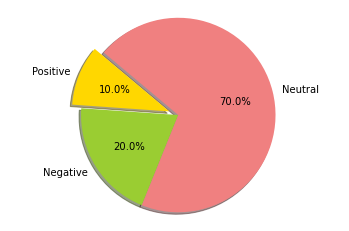

In [17]:
#Plotting sentiments
labels = 'Positive', 'Negative', 'Neutral'
sizes = [size_pos, size_neg, size_neu]
colors = ['gold', 'yellowgreen', 'lightcoral']
explode = (0.1, 0, 0)  # explode 1st slice
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

## Preprocesado

In [18]:
#Cleaning Data
#Removing @ handle
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
     
    return input_txt 

tweet_dataset['text'] = np.vectorize(remove_pattern)(tweet_dataset['text'], "@[\w]*")

tweet_dataset.head()

,num_topic,topic,user,location,language,text,retweet_count,followers_count,geo_location,created_at,compound,neg,neu,pos
0,1,caixa bankia,FerFlecha83,España,es,RT : Audio de La Hora del CAFE n°215 en \n\n🎙h...,7,1771,NaN,2020-09-10 08:44:54,0.0000,0.000,1.000,0.0
1,1,caixa bankia,FalangeSevilla,Sevilla,es,RT : Audio de La Hora del CAFE n°215 en \n\n🎙h...,7,1055,NaN,2020-09-10 08:40:11,0.0000,0.000,1.000,0.0
2,1,caixa bankia,gomeez_p,MADRID,es,RT : Audio de La Hora del CAFE n°215 en \n\n🎙h...,7,869,NaN,2020-09-10 08:39:40,0.0000,0.000,1.000,0.0
3,1,caixa bankia,gomeez_p,MADRID,es,RT : Audio de n°215 en \n\n🎙https://t.co/x2p...,5,869,NaN,2020-09-10 08:39:38,0.0000,0.000,1.000,0.0
4,1,caixa bankia,isivd,Zgz city ciudad sin ley,es,Otra vez están me**do fuera del tiesto.\n.\n...,0,287,NaN,2020-09-10 08:37:31,-0.4098,0.059,0.941,0.0


In [19]:
lang_more_repeat = tweet_dataset['language'].value_counts().idxmax()
print(lang_more_repeat)

es


In [20]:
idiom = 'spanish'
#idiom = 'english'

In [21]:
#Cleaning Tweets
corpus = []
for i in range(0, len(tweet_dataset)):
    tweet = re.sub('[^a-zA-Z0-9]', ' ', tweet_dataset['text'][i])
    tweet = tweet.lower()
    tweet = re.sub('rt', '', tweet)
    tweet = re.sub('http', '', tweet)
    tweet = re.sub('https', '', tweet)
    tweet = tweet.split()
    ps = PorterStemmer()
    tweet = [ps.stem(word) for word in tweet if not word in set(stopwords.words(idiom))]
    tweet = ' '.join(tweet)
    corpus.append(tweet)

## NUBE DE PALABRAS

Representamos mediante WordCloud una nube de palabras sobre las noticias y sus topics.

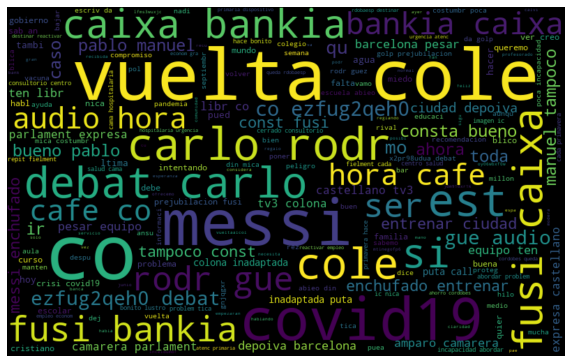

In [22]:
#Visualization
#Word Cloud
all_words = ' '.join([text for text in corpus])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

TF-IDF (funciona mucho mejor con las noticias en ingles)

In [23]:
#Term Freuency - TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000)
#tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(tweet_dataset['text'])
#Count Most Frequent Words
Counter = Counter(corpus)
most_occur = Counter.most_common(10) 
print(most_occur)

[('audio hora cafe n 215 s t co ezfug2qeh0 debat carlo rodr gue', 8), ('messi enchufado entrenar ciudad depoiva barcelona pesar equipo ten d libr s t co', 6), ('amparo 11 camarera parlament expresa castellano tv3 colona inadaptada puta call', 6), ('consta bueno pablo manuel tampoco const fusi n caixa bankia', 4), ('audio n 215 s t co x2pr98udua debat carlo rodr guez', 3), ('escuela abieo din mica costumbr poca incapacidad abordar problem tica', 3), ('imagen ic nica messi repit fielment cada primavera hace bonito lustro s t co gnjqgxr', 3), ('cerrado consultorio centro salud cama hospitalaria urgencia atenc n primaria dispositivo', 3), ('ahorro cordobes queda c rdobaesp destinar reactivar empleo econom gra', 3), ('vez est n do tiesto saben q hacer hacers notar piensan q caixa q pae aunqu sede social valencia dan cuenta q est n reglando bankia', 2)]


Comprobamos si las noticias y topics analizados y extraídos son los temas mas hablados ahora mismo en las tendencias de Twitter.

In [24]:
#api.trends_available()  #muestra los codigos por pais para buscar trends
#España=23424950

In [25]:
code_country = 23424950
trends_result = api.trends_place(code_country)  #España=23424950
for trend in trends_result[0]["trends"]:
    print(trend["name"])

#MiRecuerdoMario3D
#FelizJueves
Pablo Motos
#LaHoraSantiagoAbascal
#suicidio
#MiAyuntamientoNoSeExpropia
Idealista
Aston Martin
Habeas Corpus
Bellamy
Colin Firth
El Gobierno
Asuntos Internos
California
Hazard
Checo
Irene Montero
Raptors
Miguel Ángel Blanco
Boston
Dune
Nobel de la Paz
Franco
Congreso
Kitchen
Chimy
Oxford
Xbox
Bildu
Among Us
Sagan
La La Land
Kemba
Paco de Lucía
AstraZeneca
Donald Trump
Game 7
#memoriasdeidhún
#LaCafeteraNACHOALVAREZ
#LaHoraDeLa1
#The100
#LaEsperaPorArrakis
#Mujer17
#Madres
#NoTauromaquiaEnUnesco
#eurobombazo
#lazospacodelucía
#AcostaSeguraEH
#QuieroQueVuelvas1M
#firstdates9s
